In [395]:
import numpy as np
import pandas as pd
data = pd.read_csv('/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/mushrooms.csv')

In [396]:
data[data.columns] = data[data.columns].astype('category')


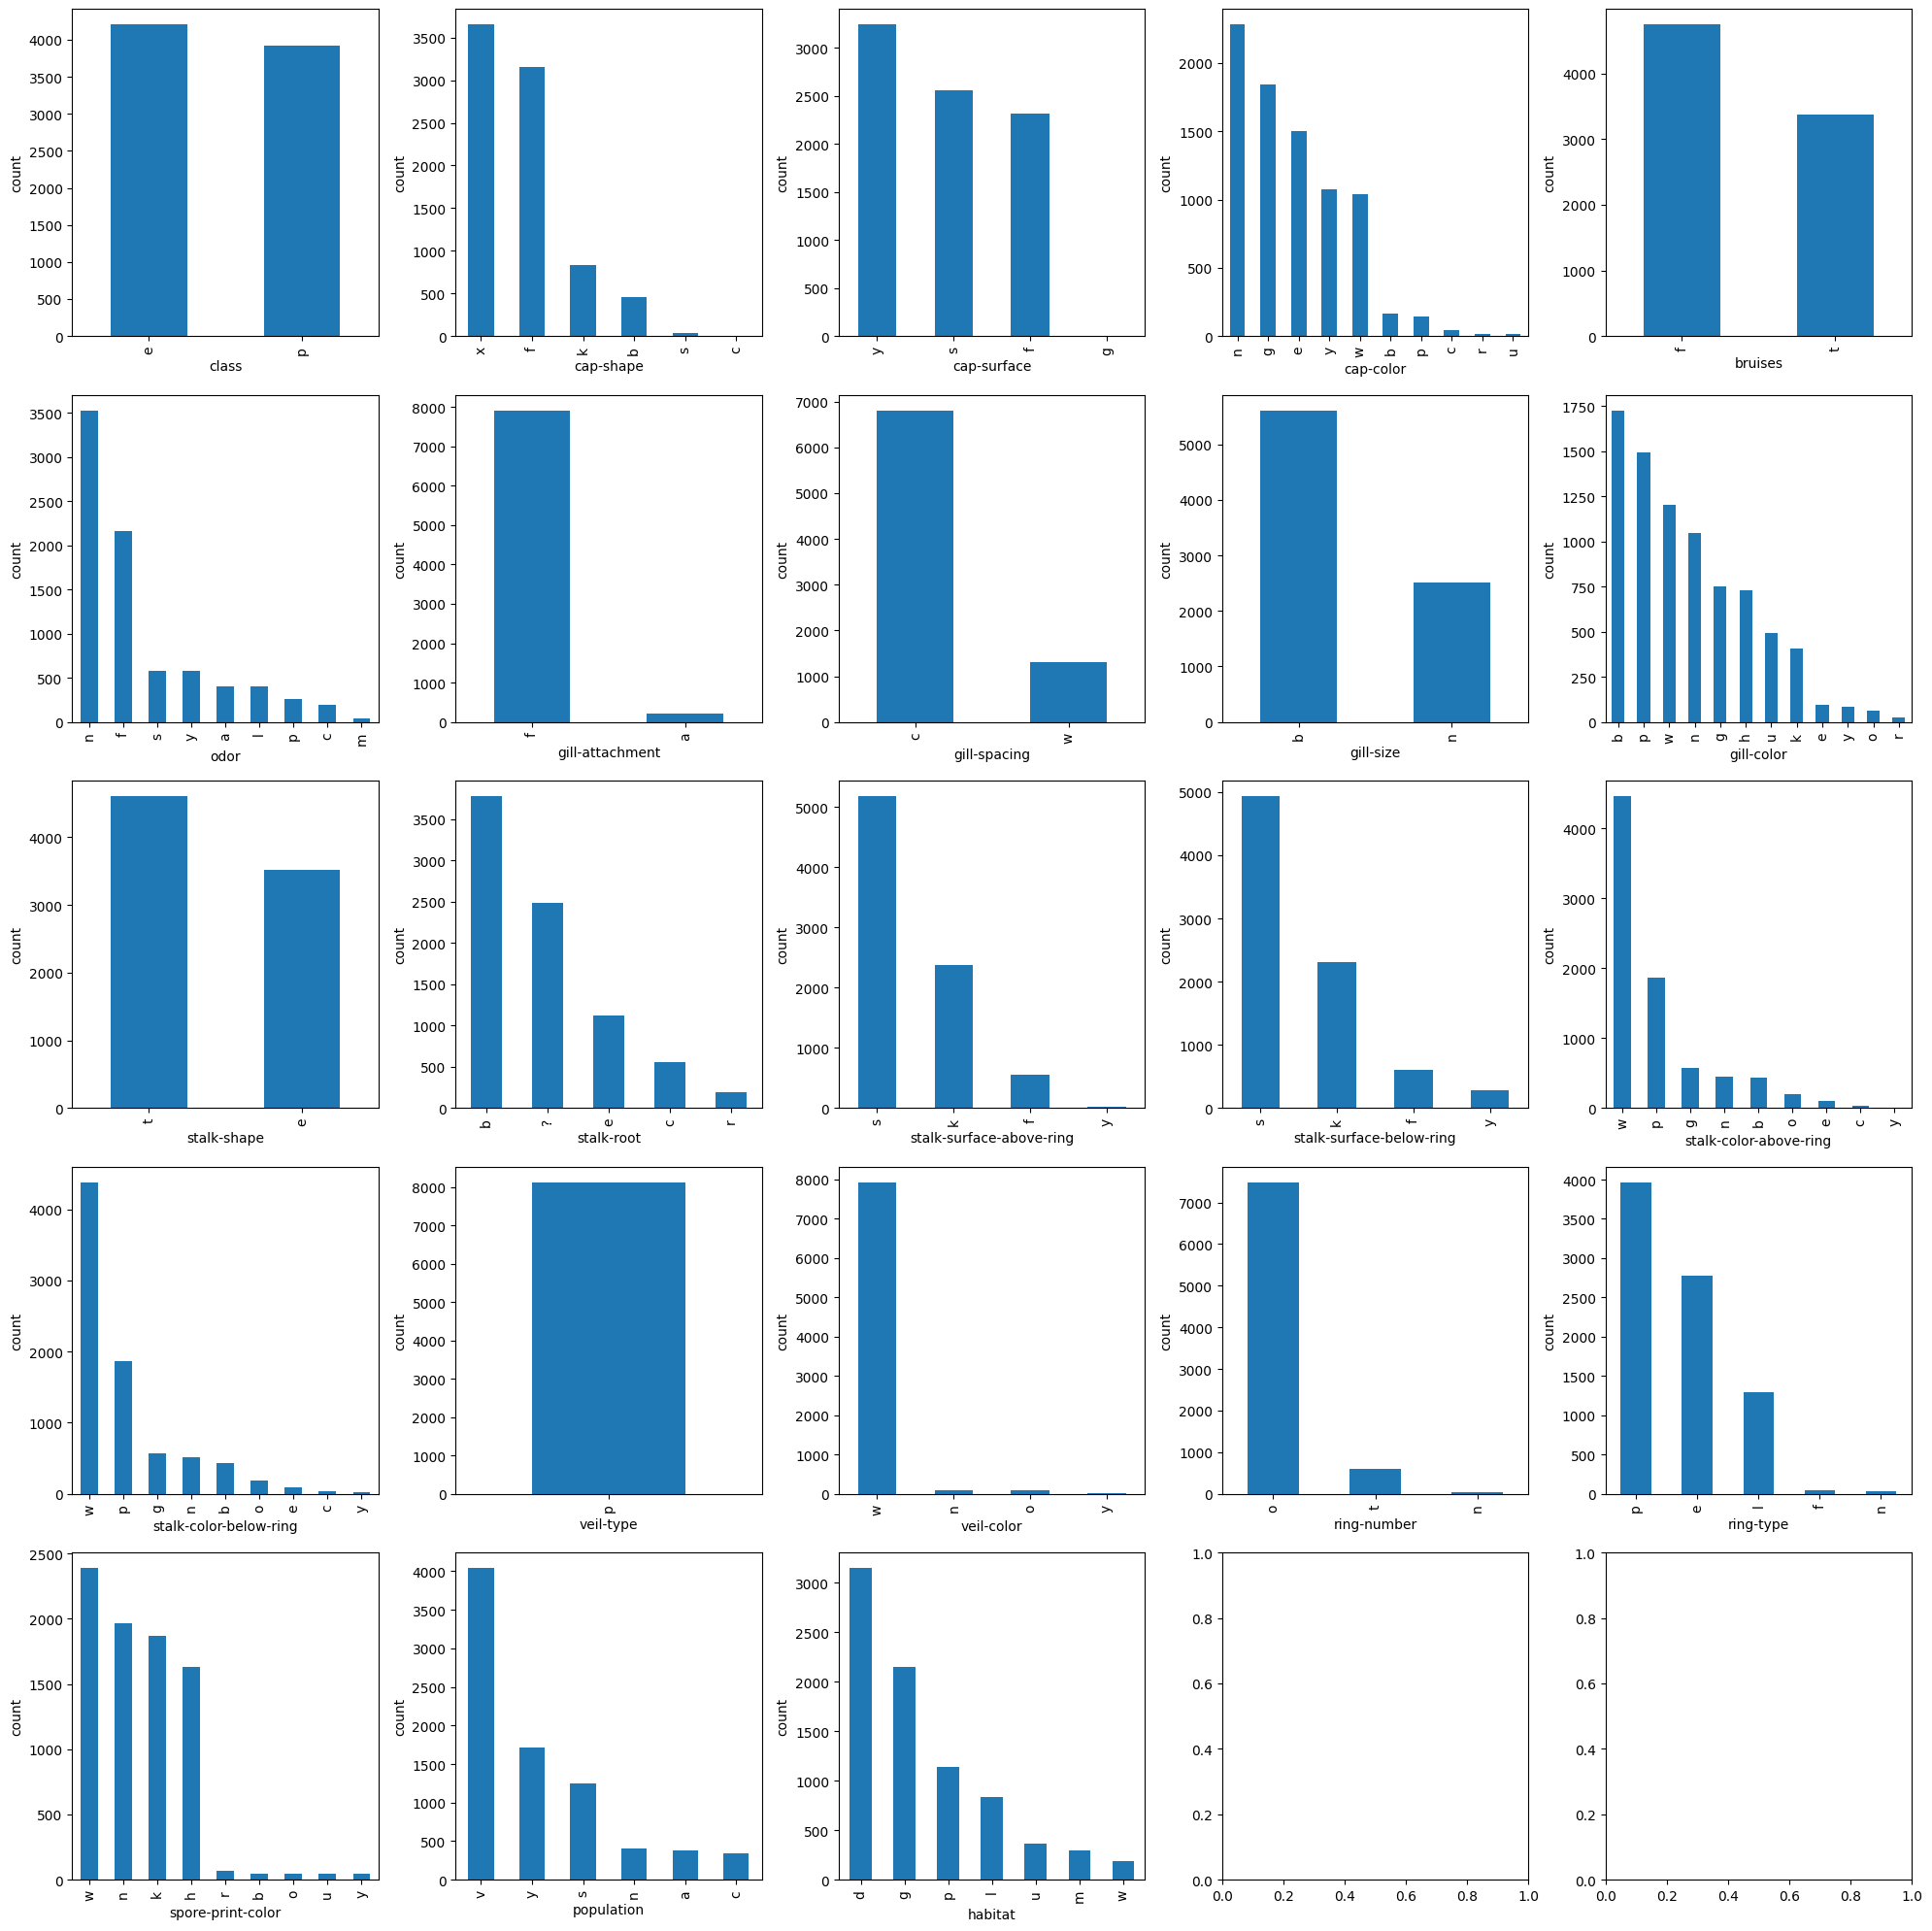

In [397]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten() 
for i, name in enumerate(data.columns):
    data[name].value_counts().plot(kind='bar', ax=axs[i], xlabel=name, ylabel='count')

plt.tight_layout()
plt.show()


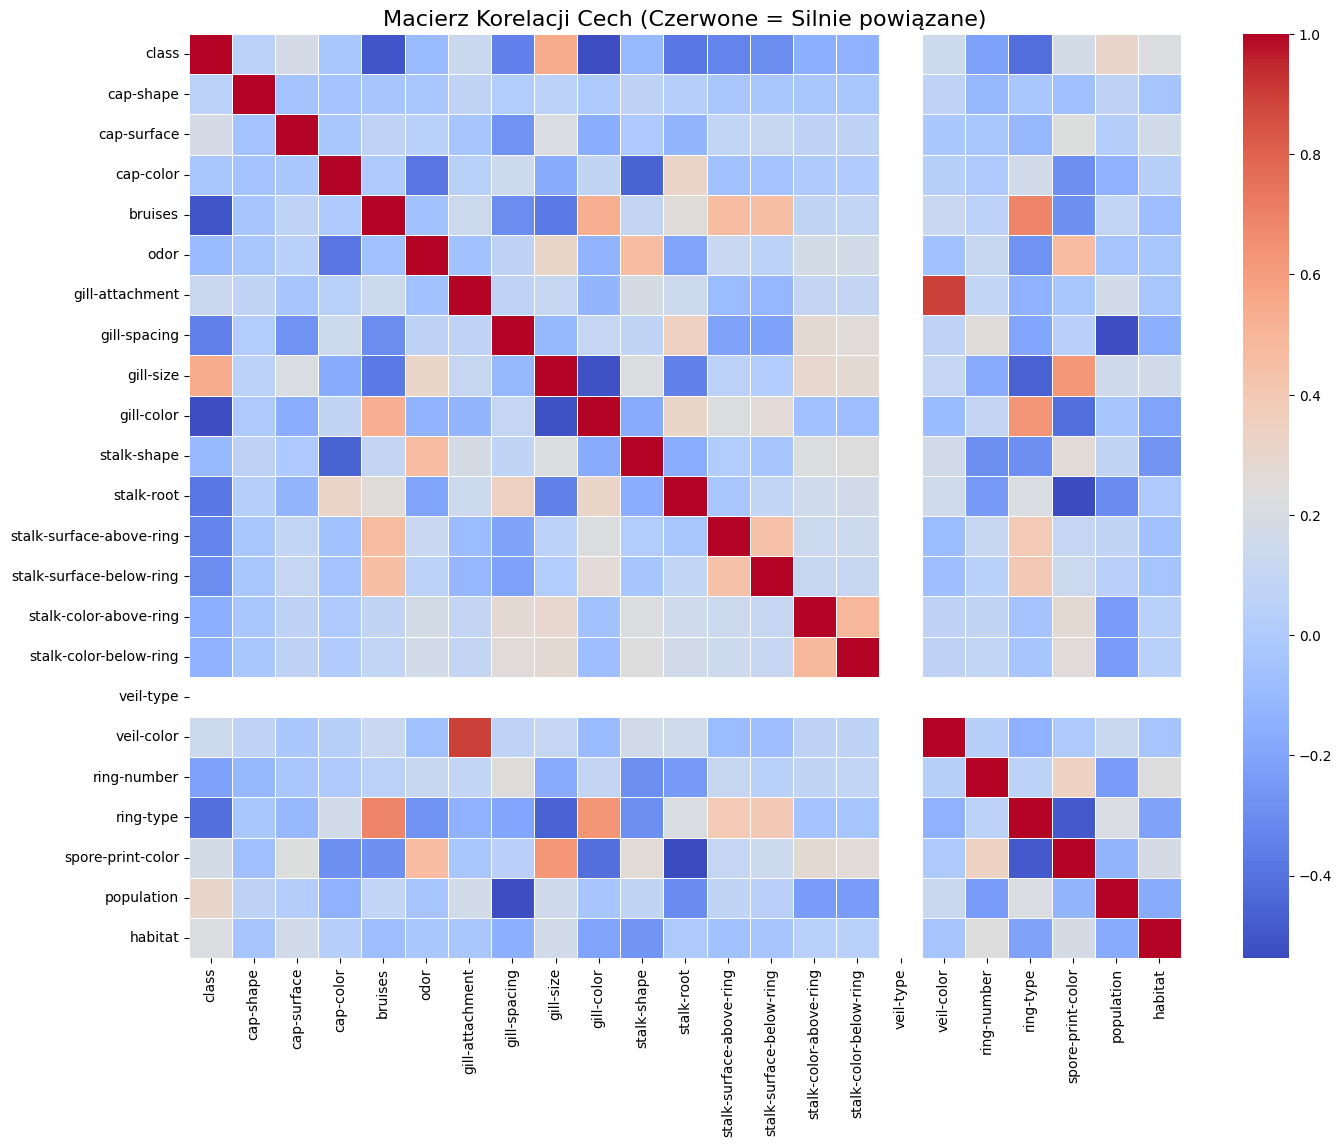

In [ ]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
df_corr = data.copy()
le = LabelEncoder()
for col in df_corr.columns:
    df_corr[col] = le.fit_transform(df_corr[col])

corr_matrix = df_corr.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Macierz korelacji cech", fontsize=16)
plt.show()

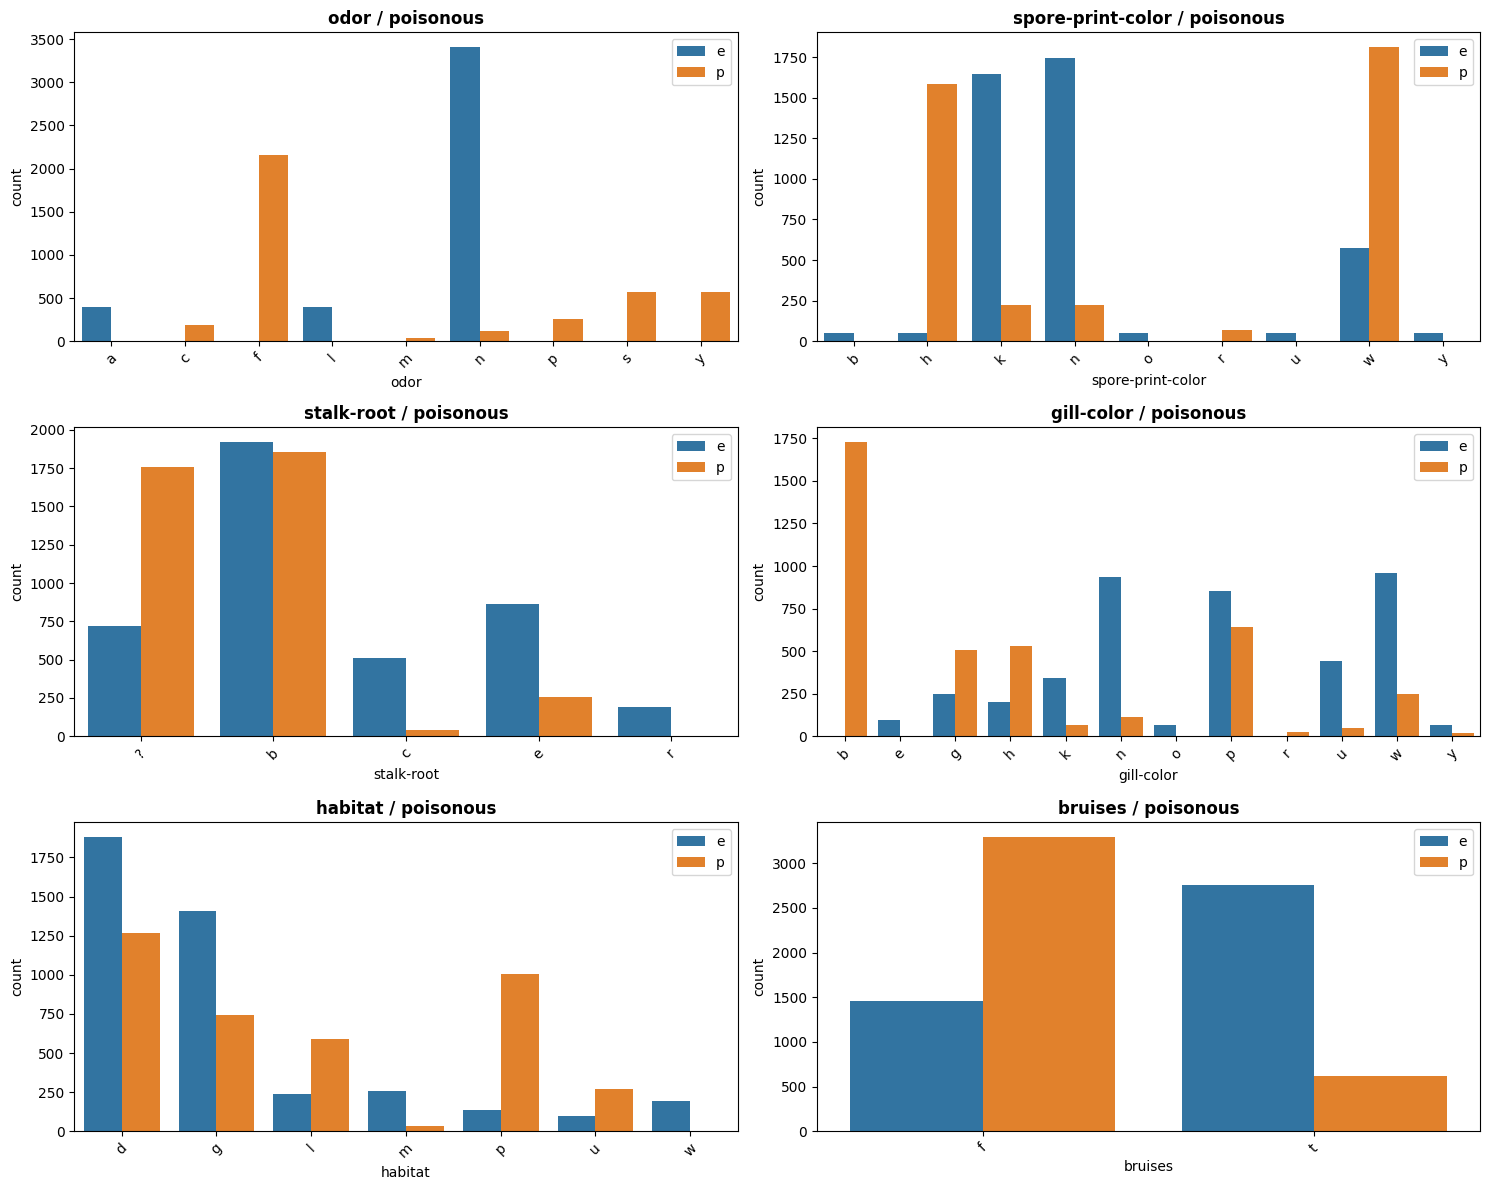

In [429]:
import math

features_to_plot = ['odor', 'spore-print-color', 'stalk-root', 'gill-color', 'habitat', 'bruises']
n_cols = 2
n_rows = math.ceil(len(features_to_plot) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axs = axs.flatten()

for i, col in enumerate(features_to_plot):
    if col in data.columns:
        sns.countplot(data, x=col, hue='class', ax=axs[i])
        
        axs[i].set_title(f'{col} / poisonous', fontweight='bold')
        axs[i].legend( loc='upper right')
        axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [399]:
'''
Ciekawa obserwacja - jesli grzyb jest smierdzacy to ZAWSZE jest trujacy, a jesli nie jest to 
w wiekszosci przypadkow jest jadalny
safe_odors = ['a', 'l', 'n']
data['is_smelly'] = data['odor'].apply(lambda x: 0 if x in safe_odors else 1)

pd.crosstab(
    index= data['is_smelly'],
    columns=data['class'],
    margins=True,
    margins_name='Suma'
)
data.drop('odor',axis=1, inplace=True)
'''


"\nCiekawa obserwacja - jesli grzyb jest smierdzacy to ZAWSZE jest trujacy, a jesli nie jest to \nw wiekszosci przypadkow jest jadalny\nsafe_odors = ['a', 'l', 'n']\ndata['is_smelly'] = data['odor'].apply(lambda x: 0 if x in safe_odors else 1)\n\npd.crosstab(\n    index= data['is_smelly'],\n    columns=data['class'],\n    margins=True,\n    margins_name='Suma'\n)\ndata.drop('odor',axis=1, inplace=True)\n"

Kod który znajduje sie powyzej jest eksperymentem, niezbyt udanym. Probowalem zastapic odor kolumna 
binarna is_smelly, ale model stawal sie mniej stabilny numerycznie i mial gorsze wyniki

In [400]:
data_copy = data.copy()
data_copy['class'] = data_copy['class'].map({'e': 0, 'p': 1})
data_copy['bruises'] = data_copy['bruises'].map({'f': 0, 't': 1})
data_copy['gill-size'] = data_copy['gill-size'].map({'n': 0, 'b': 1})
data_copy['stalk-shape'] = data_copy['stalk-shape'].map({'t': 0, 'e': 1})
mapping_gill_spacing = {'d': 0, 'c': 1, 'w': 2}
data_copy['gill-spacing'] = data_copy['gill-spacing'].map(mapping_gill_spacing)
mapping_ring_num = {'n': 0, 'o': 1, 't': 2}
data_copy['ring-number'] = data_copy['ring-number'].map(mapping_ring_num)
mapping_pop = {
    'y': 0, # solitary
    's': 1, # scattered
    'v': 2, # several
    'c': 3, # clustered
    'a': 4, # abundant
    'n': 5  # numerous
}
data_copy['population'] = data_copy['population'].map(mapping_pop)


In [401]:
print(data['stalk-root'].value_counts())
# mamy brak danych, nie podoba się nam to ale nic z tym nie robie - do tematu wroce na samym koncu. 

stalk-root
b    3776
?    2480
e    1120
c     556
r     192
Name: count, dtype: int64


In [402]:
data.iloc[:,0].value_counts()[1]/len(data.iloc[:,0])


/var/folders/45/qvg2y71577g1pl9tyk8p0p640000gn/T/ipykernel_8738/3271627078.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data.iloc[:,0].value_counts()[1]/len(data.iloc[:,0])


np.float64(0.48202855736090594)

Okej, to jest moment w którym dzielimy nasz dataset na zbior treningowy i testowy - pamietam ze nasze dane maja byc jak najbardziej reprezentatywne, korzystam ze stratify

In [403]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    data_copy, test_size=0.2, stratify=data_copy["class"], random_state=42)

In [404]:
strat_train_set.iloc[:,0].value_counts()[1]/len(strat_train_set.iloc[:,0])

np.float64(0.4820741652561933)

w tym momencie zorientowałem się, jak cięzko bedzie uzyc tych danych dla naszego modelu - trzeba zaczac kombinowac.

In [405]:
strat_train_set.drop('veil-type', axis=1, inplace=True)


In [406]:
problematic_cols = [ 'cap-shape', 'cap-surface', 'cap-color',  'odor',
       'gill-attachment', 'gill-spacing', 'gill-color',
        'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color',  'ring-type',
       'spore-print-color', 'habitat']

Teraz będziemy sprawdzać rózne sposoby kodowania zmiennych kategorycznych i to jakie najlepsze rezultaty mozemy uzyskac w naszym modelu z ich uzyciem

In [407]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder,WOEEncoder,CatBoostEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

nominal_pipeline_1 = Pipeline([
    ('encoder', TargetEncoder()),       
    ('scaler', StandardScaler())       
])
nominal_pipeline_2 = Pipeline([
    ('encoder', WOEEncoder()),       
    ('scaler', StandardScaler())       
])
nominal_pipeline_3 = Pipeline([
    ('encoder', CatBoostEncoder()),       
    ('scaler', StandardScaler())       
])

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('nominal_processing_1', nominal_pipeline_1, problematic_cols)
    ],
    remainder='passthrough' 
)
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('nominal_processing_2', nominal_pipeline_2, problematic_cols)
    ],
    remainder='passthrough' 
)
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('nominal_processing_3', nominal_pipeline_3, problematic_cols)
    ],
    remainder='passthrough' 
)


In [408]:
from sklearn.pipeline import make_pipeline
labels = strat_train_set["class"].copy()
grzyby = strat_train_set.drop("class", axis=1)

QDA_1 = make_pipeline(preprocessor_1,QuadraticDiscriminantAnalysis())
QDA_1.fit(grzyby,labels)

/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


,steps,"[('columntransformer', ...), ('quadraticdiscriminantanalysis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_processing_1', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [409]:
X_test = strat_test_set.drop("class", axis=1)
y_test = strat_test_set["class"].copy()

-Wyniki dla TargetEncodera 
Dokładność (Accuracy):  1.0000
Precyzja (Precision):   1.0000  
Czułość (Recall):       1.0000  
F1-Score:               1.0000
ROC AUC:                1.0000


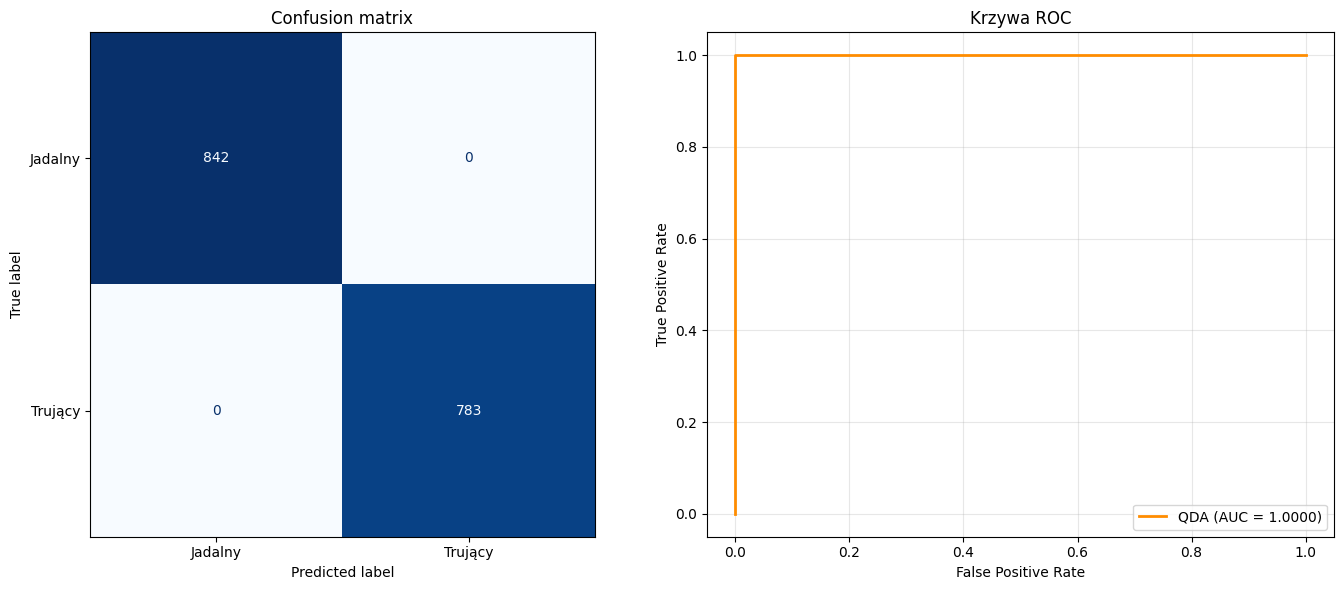

In [410]:
#1 dla targetEncodera


from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
y_pred = QDA_1.predict(X_test)

y_proba = QDA_1.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"-Wyniki dla TargetEncodera ")
print(f"Dokładność (Accuracy):  {acc:.4f}")
print(f"Precyzja (Precision):   {prec:.4f}  ")
print(f"Czułość (Recall):       {rec:.4f}  ")
print(f"F1-Score:               {f1:.4f}")
print(f"ROC AUC:                {auc:.4f}")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Jadalny', 'Trujący'])
disp.plot(cmap='Blues', ax=ax1, colorbar=False)
ax1.set_title("Confusion matrix")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
ax2.plot(fpr, tpr, label=f'QDA (AUC = {auc:.4f})', color='darkorange', lw=2)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Krzywa ROC')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Oj, coś za dobrze poszło. Z kronikarskiego obowiązku sprawdzę tez inne metody

In [411]:
QDA_2 = make_pipeline(preprocessor_2,QuadraticDiscriminantAnalysis(reg_param=0.01))
QDA_2.fit(grzyby,labels)


,steps,"[('columntransformer', ...), ('quadraticdiscriminantanalysis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_processing_2', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


-Wyniki dla WOEEncodera 
Dokładność (Accuracy):  0.9982
Precyzja (Precision):   1.0000  
Czułość (Recall):       0.9962  
F1-Score:               0.9981
ROC AUC:                1.0000


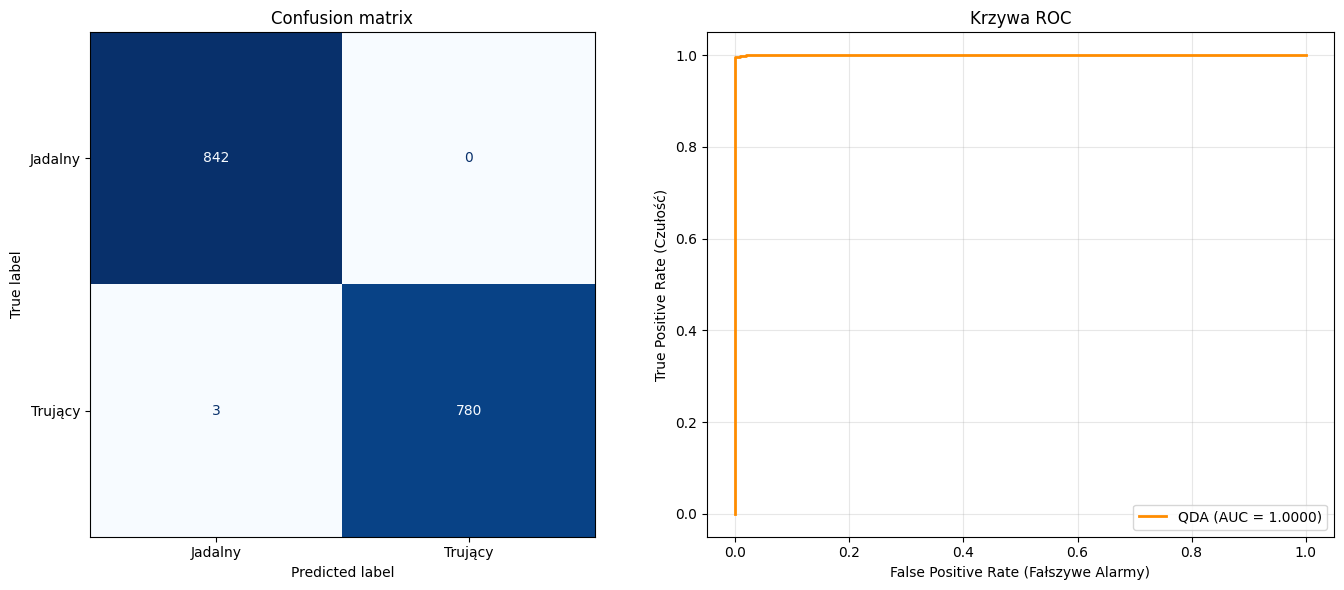

In [412]:
#2 dla tarWOEEncodera

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
y_pred = QDA_2.predict(X_test)
y_proba = QDA_2.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"-Wyniki dla WOEEncodera ")
print(f"Dokładność (Accuracy):  {acc:.4f}")
print(f"Precyzja (Precision):   {prec:.4f}  ")
print(f"Czułość (Recall):       {rec:.4f}  ")
print(f"F1-Score:               {f1:.4f}")
print(f"ROC AUC:                {auc:.4f}")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Jadalny', 'Trujący'])
disp.plot(cmap='Blues', ax=ax1, colorbar=False)
ax1.set_title("Confusion matrix")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
ax2.plot(fpr, tpr, label=f'QDA (AUC = {auc:.4f})', color='darkorange', lw=2)
ax2.set_xlabel('False Positive Rate (Fałszywe Alarmy)')
ax2.set_ylabel('True Positive Rate (Czułość)')
ax2.set_title('Krzywa ROC')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [413]:
QDA_3 = make_pipeline(preprocessor_3,QuadraticDiscriminantAnalysis())
QDA_3.fit(grzyby,labels)

,steps,"[('columntransformer', ...), ('quadraticdiscriminantanalysis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal_processing_3', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


-Wyniki dla CatBoostEncodera 
Dokładność (Accuracy):  0.9982
Precyzja (Precision):   1.0000  
Czułość (Recall):       0.9962  
F1-Score:               0.9981
ROC AUC:                0.9999


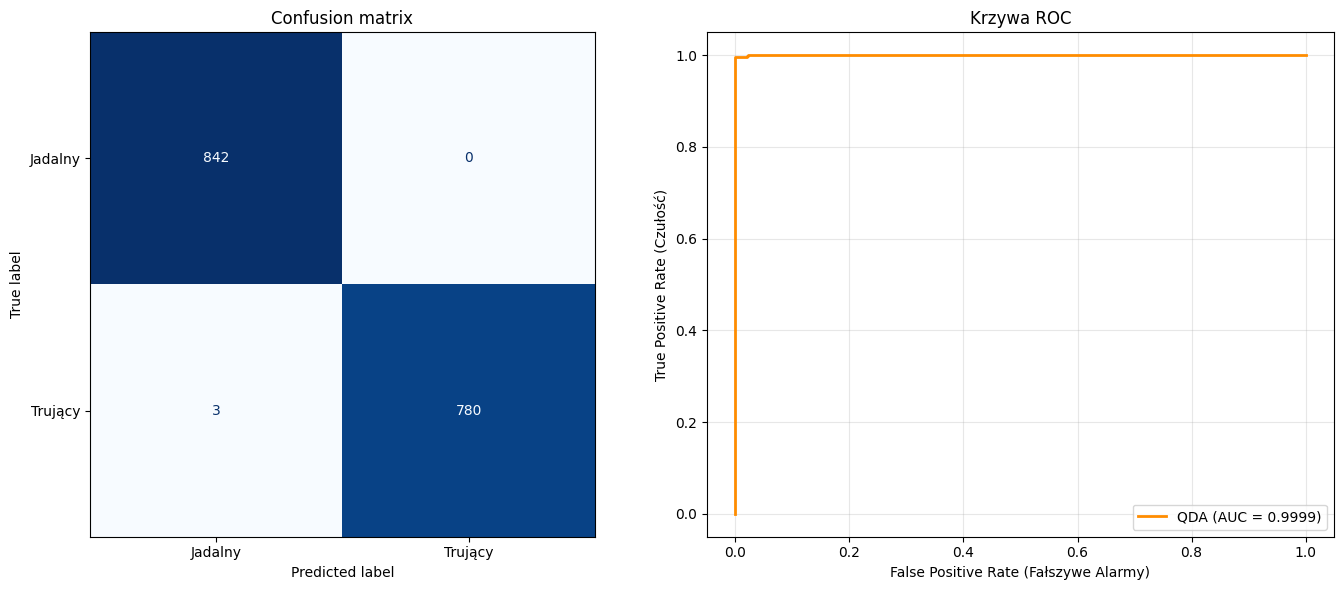

In [414]:
#3 dla CatBoostEncodera

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix,
    ConfusionMatrixDisplay
)
y_pred = QDA_3.predict(X_test)
y_proba = QDA_3.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"-Wyniki dla CatBoostEncodera ")
print(f"Dokładność (Accuracy):  {acc:.4f}")
print(f"Precyzja (Precision):   {prec:.4f}  ")
print(f"Czułość (Recall):       {rec:.4f}  ")
print(f"F1-Score:               {f1:.4f}")
print(f"ROC AUC:                {auc:.4f}")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Jadalny', 'Trujący'])
disp.plot(cmap='Blues', ax=ax1, colorbar=False)
ax1.set_title("Confusion matrix")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
ax2.plot(fpr, tpr, label=f'QDA (AUC = {auc:.4f})', color='darkorange', lw=2)
ax2.set_xlabel('False Positive Rate (Fałszywe Alarmy)')
ax2.set_ylabel('True Positive Rate (Czułość)')
ax2.set_title('Krzywa ROC')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Coś pięknego - pierwsze dwa encodery sa wspaniale,  trzeci troche gorszy - sprawdzimy jeszcze jak radzi sobie nasz model przy cross- validacji.

In [415]:
# Arbitralnie uznałem, ze najlepsza miara naszego modelu jest recall - chcemy miec pewnosc ze kazdy grzyb trujacy, 
# zostanie jako taki zidentyfikowany
from sklearn.model_selection import cross_val_score, StratifiedKFold


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(QDA_1, grzyby, labels, cv=kfold, scoring='recall')
print(f"Średni recall - wykrywalność trucizny dla 1 encodera: {np.mean(scores):.4f}")

/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analy

Średni recall - wykrywalność trucizny dla 1 encodera: 0.9984


/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analy

In [416]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(QDA_2, grzyby, labels, cv=kfold, scoring='recall')
print(f"Średni recall - wykrywalność trucizny dla 2 encodera: {np.mean(scores):.4f}")

Średni recall - wykrywalność trucizny dla 2 encodera: 0.9968


In [417]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(QDA_3, grzyby, labels, cv=kfold, scoring='recall')
print(f"Średni recall - wykrywalność trucizny dla 3 encodera: {np.mean(scores):.4f}")

Średni recall - wykrywalność trucizny dla 3 encodera: 0.9984


Okej, dla tych 3 encoderow mamy dosc podobne wyniki. Przy pierwszych dwoch jednak okazuje sie, ze po 
encodowaniu naszych zmiennych kategorycznych wiele wiele kolumn jest ze soba silnie liniowo powiazanych (stad warning 'LinAlgWarning: The covariance matrix of class 0 is not full rank.'), co sprawia ze dla nowych danych moga one gorzej performowac (a przynajmniej tak mi sie intuicyjnie wydaje). W dalszych rozwazaniach dla naszych QDA bede ustawiał parametr reg_param

Tak naprawde na tym moglbym skonczyc ten projekt, mamy dobry efektywny model. Ale ten ułamek procenta to sprawa zycia i smierci - sprobujemy go usunac.
Jednym sposobem na to, byloby obnizenie progu wykrywalności grzybów trujących w naszym modelu.



In [418]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.001, 0.0001, 0.00001, 0.5, 0.8]
}

search = GridSearchCV(
    QDA_1,               
    param_grid,
    cv=10,              
    scoring='recall'           
)
search.fit(grzyby, labels)

print(f"Najlepszy reg_param: {search.best_params_['quadraticdiscriminantanalysis__reg_param']}")
print(f"Najlepszy Recall:    {search.best_score_:.4f}")




/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analy

Najlepszy reg_param: 0.0
Najlepszy Recall:    0.9984


/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [419]:
search = GridSearchCV(
    QDA_2,               
    param_grid,
    cv=10,              
    scoring='recall'           
)
search.fit(grzyby, labels)

print(f"Najlepszy reg_param: {search.best_params_['quadraticdiscriminantanalysis__reg_param']}")
print(f"Najlepszy Recall:    {search.best_score_:.4f}")

/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analy

Najlepszy reg_param: 0.0001
Najlepszy Recall:    0.9994


In [420]:
search = GridSearchCV(
    QDA_3,               
    param_grid,
    cv=10,              
    scoring='recall'           
)
search.fit(grzyby, labels)

print(f"Najlepszy reg_param: {search.best_params_['quadraticdiscriminantanalysis__reg_param']}")
print(f"Najlepszy Recall:    {search.best_score_:.4f}")

Najlepszy reg_param: 0.0
Najlepszy Recall:    0.9981


Okej, najlepszy wynik otrzymujemy dla modelu drugiego i reg_param = 0.0001 - a jak to wyglada na wzorze testowym?

In [421]:
QDA_2 = make_pipeline(preprocessor_2,QuadraticDiscriminantAnalysis(reg_param=0.0001))

QDA_2.fit(grzyby,labels)
y_pred = QDA_2.predict(X_test)
y_proba = QDA_2.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"-Wyniki dla WOEEncodera ")
print(f"Dokładność (Accuracy):  {acc:.4f}")
print(f"Precyzja (Precision):   {prec:.4f}  ")
print(f"Czułość (Recall):       {rec:.4f}  ")
print(f"F1-Score:               {f1:.4f}")
print(f"ROC AUC:                {auc:.4f}")

-Wyniki dla WOEEncodera 
Dokładność (Accuracy):  1.0000
Precyzja (Precision):   1.0000  
Czułość (Recall):       1.0000  
F1-Score:               1.0000
ROC AUC:                1.0000


Wowowow niezle - teraz, sprawdzmy czy obnizajac prog przy podejmowaniu decyzji przez model nie moglibysmy doprowadzic recalla do 1 dla cross -val.

/Users/mateuszosak/Documents/CERN_grind/ZadanieDrugie/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


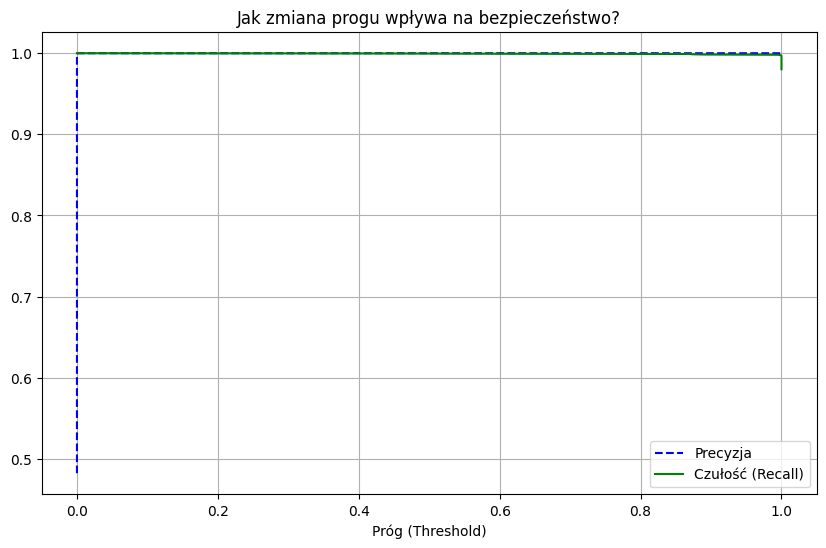

Recall przy progu 0.0001: 1.0000


In [422]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
y_probas = cross_val_predict(QDA_2, grzyby, labels, cv=10, method="predict_proba")

y_scores = y_probas[:, 1] 

precisions, recalls, thresholds = precision_recall_curve(labels, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja")
plt.plot(thresholds, recalls[:-1], "g-", label="Czułość (Recall)")
plt.xlabel("Próg (Threshold)")
plt.title("Jak zmiana progu wpływa na bezpieczeństwo?")
plt.legend()
plt.grid()
plt.show()

THRESHOLD = 0.0001  # wybieram recznie
y_safe_pred = (y_scores > THRESHOLD)
final_recall = recall_score(labels, y_safe_pred)
print(f"Recall przy progu {THRESHOLD}: {final_recall:.4f}")

Fenomenalnie! teraz zostala nam tylko jedna rzecz do sprawdzenia, mianowicie jakie były najistotniejsze cechy, ktore wplywaly na decyzje naszego modelu. 

                Cecha      Waga
19  spore-print-color  0.191954
4                odor  0.100255
10         stalk-root  0.034355
3             bruises  0.014559
17        ring-number  0.013282
9         stalk-shape  0.012516
7           gill-size  0.011367
18          ring-type  0.004981
16         veil-color  0.004215
6        gill-spacing  0.003959


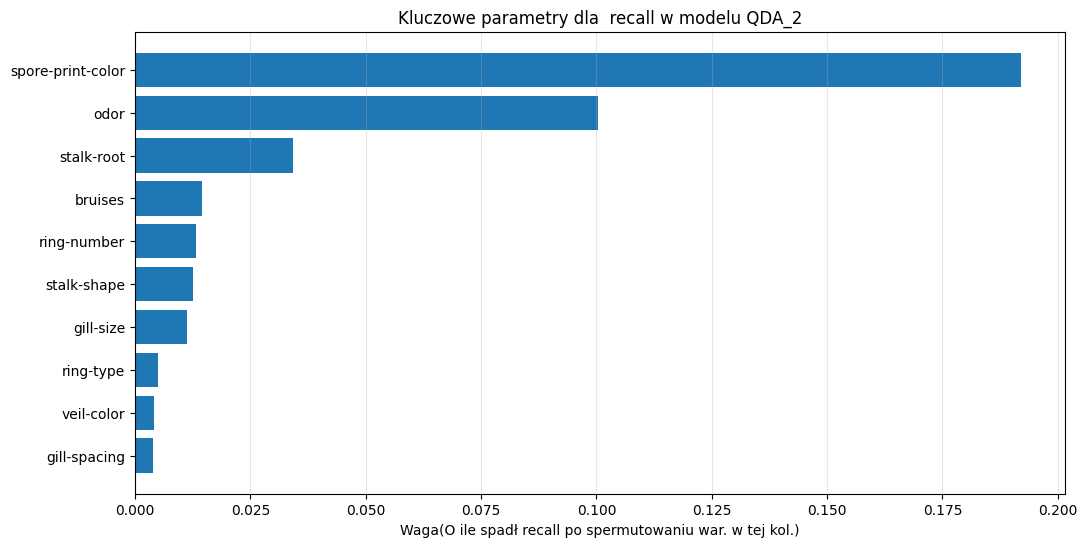

In [423]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# przyznaje, nie znalem wczesniej tej funkcji
result = permutation_importance(
    QDA_2, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='recall'
)


feature_names = X_test.columns

importances = pd.DataFrame({
    'Cecha': feature_names,
    'Waga': result.importances_mean,
})
importances = importances.sort_values(by='Waga', ascending=False)

print(importances.head(10))

plt.figure(figsize=(12, 6))
top_features = importances.head(10).sort_values(by='Waga', ascending=True)

plt.barh(top_features['Cecha'], top_features['Waga'])
plt.xlabel("Waga(O ile spadł recall po spermutowaniu war. w tej kol.)")
plt.title("Kluczowe parametry dla  recall w modelu QDA_2")
plt.grid(axis='x', alpha=0.3)
plt.show()

Mamy i nasze wyniki - i muszę przyznać, ze bardzo sie zdziwilem. 
Spore- print- color (kolor sladu zarodnikow??) okazal sie najistotniejsza cechą, zaraz za nim jest zapach grzyba
po tym stalk-root(korzen lodygi), reszta nie jest az tak istotna.

In [424]:
tabela_zaleznosci = pd.crosstab(
    index=data['stalk-root'], 
    columns=data['class'],
    margins=True,          
    margins_name="Suma"
)
tabela_zaleznosci

class,e,p,Suma
stalk-root,,,
?,720,1760,2480
b,1920,1856,3776
c,512,44,556
e,864,256,1120
r,192,0,192
Suma,4208,3916,8124


W pierwszej kolejnosci zapomnialem przejzec wartosci w stalk-root i nie zaauwazylem ze figuruje 
tam znak zapytania, czyli informacja ze nie wiadomo jaki jest ksztalt lodygi. Na samym koncu, przy 
sprawdzaniu calego zadania postanowilem sie temu przyjzec. Okazało się, ze brak informacji o kształcie
lodygi silnie koreluje z 'trującością' grzyba. Okazało się, ze na pierwszy rzut oka destrukcyjnie
działająca na model kolumna stalk-root zawiera ciekawe informacje.
